In [20]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdmolops, AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys


from scipy.stats import pearsonr


# sklearn ML models
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import  LGBMRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import KFold

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity='all'


In [21]:
df_exp = pd.read_csv('../01-database-preprocessing-1203dp-to-1115dp/building-block-donor.csv')
df_exp.head()

,Nickname,bandgap(eV),c_smiles,newSMILES,Ref.No,bdt,fluorene,cpdt,tdt,others
0,P3HT,1.93,CCCCCCc1cc(C)sc1C,Cc1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C...,S10,0,0,0,0,1
1,P3HST,1.82,CCCCCCSc1cc(C)sc1C,CSc1cc(sc1C)-c1sc(cc1SC)-c1sc(cc1SC)-c1sc(cc1S...,S123,0,0,0,0,1
2,POPT,1.76,CCCCCCCCc1ccc(-c2cc(C)sc2C)cc1,Cc1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c...,S126,0,0,0,0,1
3,PT-C1,1.92,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(C)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1cc(C(=O)OC)c(s1)...,S122,0,0,0,0,1
4,PT-C2,1.89,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(-c2ccc(C)s2)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1ccc(s1)-c1cc(C(=...,S122,0,0,0,0,1


In [22]:
df_exp.shape

(1096, 10)

# DFT gap

In [23]:
df = pd.read_csv('./DFT/scf-6-31gs.csv')
scf = df[['HOMO-LUMO(eV)']]
scf

,HOMO-LUMO(eV)
0,2.78726
1,2.72032
2,3.19979
3,2.69964
4,2.66372
...,...
1110,1.93038
1111,1.93065
1112,2.04439
1113,1.94561


In [24]:
df[np.isnan(df).any(axis=1)==True]


,E(6-31G*)(Har),HOMO(eV),LUMO(eV),HOMO-LUMO(eV),X,Y,Z,Tot
691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# drop sp3-N polymers + donor-692

In [25]:
sp3_N_list = [  24,   44,  191,  201,  206,  209,  251,  317,  318,  332,  374,
             381,  388,  454,  913,  931,  936, 1006]
drop_list = sp3_N_list+[691]
print('Total data points: ', 1115-len(drop_list))

Total data points:  1096


In [26]:
df_dft = scf[~scf.index.isin(drop_list)].reset_index(drop=True)
df_dft.shape

(1096, 1)

In [27]:
df_data = pd.concat([df_exp, df_dft], axis=1)
df_data

,Nickname,bandgap(eV),c_smiles,newSMILES,Ref.No,bdt,fluorene,cpdt,tdt,others,HOMO-LUMO(eV)
0,P3HT,1.93,CCCCCCc1cc(C)sc1C,Cc1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C...,S10,0,0,0,0,1,2.78726
1,P3HST,1.82,CCCCCCSc1cc(C)sc1C,CSc1cc(sc1C)-c1sc(cc1SC)-c1sc(cc1SC)-c1sc(cc1S...,S123,0,0,0,0,1,2.72032
2,POPT,1.76,CCCCCCCCc1ccc(-c2cc(C)sc2C)cc1,Cc1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c...,S126,0,0,0,0,1,3.19979
3,PT-C1,1.92,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(C)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1cc(C(=O)OC)c(s1)...,S122,0,0,0,0,1,2.69964
4,PT-C2,1.89,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(-c2ccc(C)s2)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1ccc(s1)-c1cc(C(=...,S122,0,0,0,0,1,2.66372
...,...,...,...,...,...,...,...,...,...,...,...
1091,BTT-NTz,1.68,CCCCCCCCCCCCc1cc(C)sc1-c1cc2c3sc(C(CCCCCCCC)CC...,Cc1cc(C)c(s1)-c1cc2c3sc(C)cc3c3cc(sc3c2s1)-c1s...,S115,0,0,0,0,1,1.93038
1092,PIDTI-BT,1.65,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,Cc1cc2n(C)c3cc4-c5cc6c(cc5C(c4cc3c2s1)(c1ccccc...,S441,0,1,0,0,0,1.93065
1093,PIDTI-DTBT,1.66,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,Cc1ccc(s1)-c1ccc(-c2ccc(s2)-c2cc3n(C)c4cc5-c6c...,S441,0,1,0,0,0,2.04439
1094,poly(DPP4T-alt-TBP),1.52,CCCCCCCCCCCCC(CCCCCCCCCC)CN1C(=O)C2=C(c3ccc(-c...,CN1C(=O)C2=C(N(C)C(=O)C2=C1c1ccc(C)s1)c1ccc(s1...,S464,0,0,0,0,1,1.94561


In [28]:
df_data['type'] = 0
df_data.loc[df_data['bdt']==1, ['type']]=0
df_data.loc[df_data['fluorene']==1, ['type']]=1
df_data.loc[df_data['cpdt']==1, ['type']]=2
df_data.loc[df_data['tdt']==1, ['type']]=3
df_data.loc[df_data['others']==1, ['type']]=4


df_data

,Nickname,bandgap(eV),c_smiles,newSMILES,Ref.No,bdt,fluorene,cpdt,tdt,others,HOMO-LUMO(eV),type
0,P3HT,1.93,CCCCCCc1cc(C)sc1C,Cc1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C...,S10,0,0,0,0,1,2.78726,4
1,P3HST,1.82,CCCCCCSc1cc(C)sc1C,CSc1cc(sc1C)-c1sc(cc1SC)-c1sc(cc1SC)-c1sc(cc1S...,S123,0,0,0,0,1,2.72032,4
2,POPT,1.76,CCCCCCCCc1ccc(-c2cc(C)sc2C)cc1,Cc1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c...,S126,0,0,0,0,1,3.19979,4
3,PT-C1,1.92,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(C)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1cc(C(=O)OC)c(s1)...,S122,0,0,0,0,1,2.69964,4
4,PT-C2,1.89,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(-c2ccc(C)s2)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1ccc(s1)-c1cc(C(=...,S122,0,0,0,0,1,2.66372,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1091,BTT-NTz,1.68,CCCCCCCCCCCCc1cc(C)sc1-c1cc2c3sc(C(CCCCCCCC)CC...,Cc1cc(C)c(s1)-c1cc2c3sc(C)cc3c3cc(sc3c2s1)-c1s...,S115,0,0,0,0,1,1.93038,4
1092,PIDTI-BT,1.65,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,Cc1cc2n(C)c3cc4-c5cc6c(cc5C(c4cc3c2s1)(c1ccccc...,S441,0,1,0,0,0,1.93065,1
1093,PIDTI-DTBT,1.66,CCCCCCCCCCCCC(CCCCCCCCCC)Cn1c2cc3c(cc2c2sc(C)c...,Cc1ccc(s1)-c1ccc(-c2ccc(s2)-c2cc3n(C)c4cc5-c6c...,S441,0,1,0,0,0,2.04439,1
1094,poly(DPP4T-alt-TBP),1.52,CCCCCCCCCCCCC(CCCCCCCCCC)CN1C(=O)C2=C(c3ccc(-c...,CN1C(=O)C2=C(N(C)C(=O)C2=C1c1ccc(C)s1)c1ccc(s1...,S464,0,0,0,0,1,1.94561,4


In [29]:
df_data['type'].value_counts()

0    512
4    329
1    107
2     75
3     73
Name: type, dtype: int64

# linear fit for each donor unit group

## metrics

In [30]:
def acc(y_test,y_pred):
    MSE = mean_squared_error(y_test,y_pred)
    RMSE = MSE ** 0.5
    R2 = r2_score(y_test,y_pred)
    r, p_value = pearsonr(y_test,y_pred) # y_pred shape = (xxx,)
    MAE = mean_absolute_error(y_test,y_pred)
    return RMSE, R2, r, MAE

In [31]:
label_list = ['BDT', 'FR', 'CPDT', 'TDT', 'Others']
scores = []
for i in range(len(label_list)):
    label=label_list[i]
    X = df_data[df_data['type']==i][['HOMO-LUMO(eV)']]
    y = df_data[df_data['type']==i]['bandgap(eV)']
    model = LinearRegression()
    model.fit(X,y)
    y_pred = model.predict(X)
    RMSE, R2, r, MAE = acc(y,y_pred)
    scores.append([RMSE, R2, r, MAE])
    

scores_df = pd.DataFrame(scores, columns = ['RMSE', 'R2', 'r', 'MAE'])
scores_df.index = label_list
scores_df.round(3)


,RMSE,R2,r,MAE
BDT,0.137,0.419,0.647,0.106
FR,0.161,0.576,0.759,0.116
CPDT,0.120,0.618,0.786,0.100
TDT,0.148,0.313,0.559,0.115
Others,0.141,0.555,0.745,0.110


In [13]:
# scores_df.round(3).to_csv('donor_unit_metrics_linear_fit.csv')

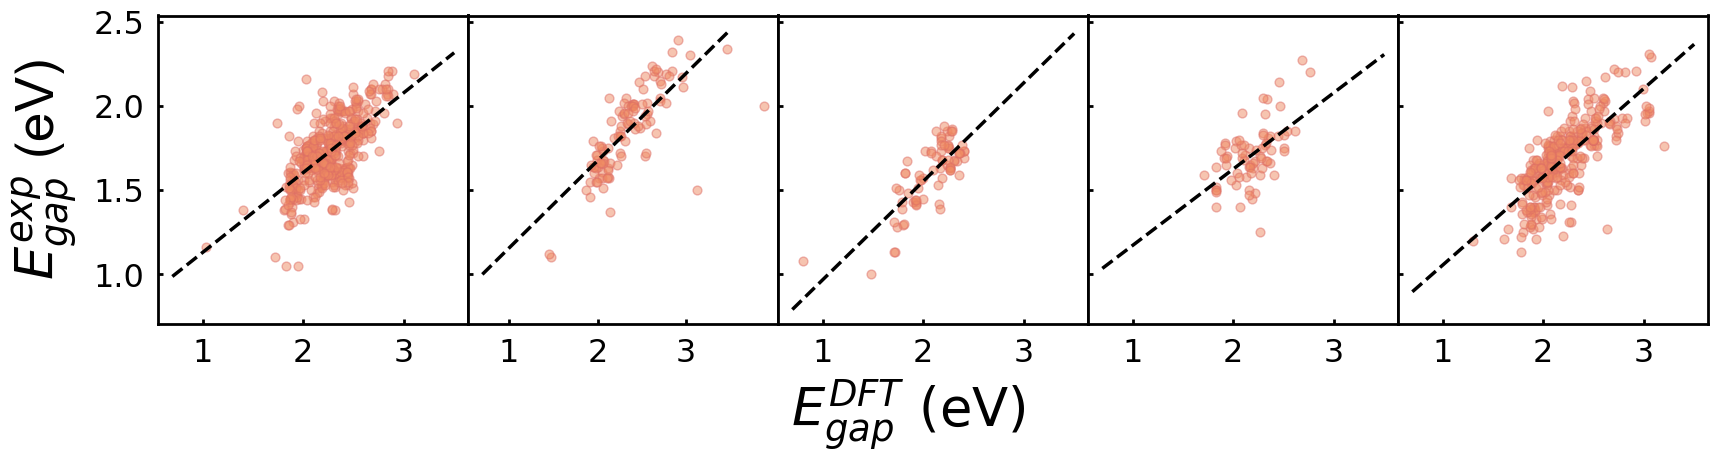

In [51]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True, gridspec_kw={'wspace': 0})
for i,label in enumerate(label_list):
    #linear fit
    label=label_list[i]
    X = df_data[df_data['type']==i][['HOMO-LUMO(eV)']]
    y = df_data[df_data['type']==i]['bandgap(eV)']
    model = LinearRegression()
    model.fit(X,y)
    a  = model.intercept_ #截距 
    b = model.coef_ #回归系数
    
    y_pred = model.predict(X)

    RMSE, R2, r, MAE = acc(y,y_pred)  
    
    xmax = X.max()
    xmin = X.min()
    xmax=3.5
    xmin=0.7
    ymax = b[0]*xmax+a
    ymin = b[0]*xmin+a
    
### scatter plot
    axes[i].plot((xmin,xmax), (ymin,ymax), ls='--', c='black', linewidth=2.5, label=f"$R^2$={round(R2,2)}") 

    axes[i].scatter(x=X, y=y, label=label, s=40, 
                    alpha=0.5, 
#                     edgecolor='black',
                    edgecolor='#DE6E66',
                    linewidth=1,
#                     color=colors[i]
                    color = '#ef8a62'
                   )
#     axes[i].legend(fontsize=20)

#     if i==0:
#         xticks=[1,2,3]
#     if i==1:
#         xticks=[2.3, 2.6]
#     if i==2:
#         xticks=[2.0, 2.3, 2.6]
#     if i==3:
#         xticks=[2.0, 2.3]
#     if i==4:
#         xticks=[2.0, 2.3, 2.6]
    xticks=[1,2,3]
    axes[i].set_xticks(xticks)

    yticks=[1,1.5,2,2.5]
    axes[i].set_yticks(yticks)
    axes[i].tick_params(direction='in', width=2)
    axes[i].tick_params(axis='x', labelsize=23, pad=10)
    axes[i].tick_params(axis='y', labelsize=23, pad=10)
#     axes[i].set_xlim(xmin,xmax)
#     axes[i].set_ylim(xmin,xmax)
    if i==0:
        axes[i].set_ylabel('$E_{gap}^{exp}$ (eV)', fontsize=38, font="arial", labelpad=10)

    for spine in axes[i].spines.values():
        spine.set_linewidth(2)
fig.text(0.5, -0.15, '$E_{gap}^{DFT}$ (eV)', ha='center', fontsize=38)
plt.show()

# Parity plot

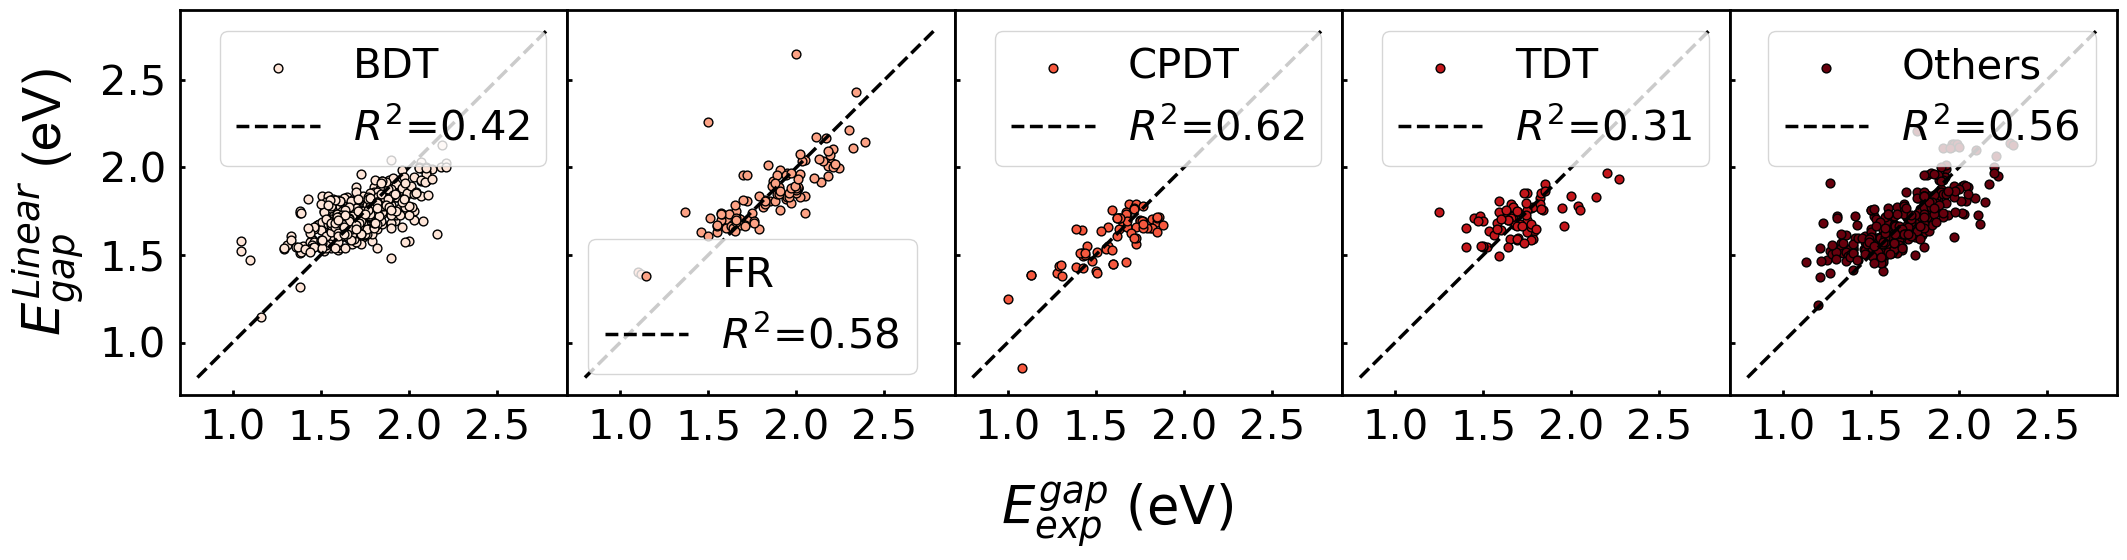

In [43]:
colormap = plt.get_cmap('Reds')
colors = colormap(np.linspace(0.1,1,5))
# xmin=df_data['bandgap(eV)'].min()
# xmax=df_data['bandgap(eV)'].max()
# print('max=',xmax, 'min=', xmin)

xmin=0.8
xmax=2.8
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True, gridspec_kw={'wspace': 0})
for i,label in enumerate(label_list):

### linear fit
    X = df_data[df_data['type']==i][['HOMO-LUMO(eV)']]
    y = df_data[df_data['type']==i]['bandgap(eV)']
    model.fit(X,y)
    y_pred = model.predict(X)
    RMSE, R2, r, MAE = acc(y,y_pred)    

### scatter plot

    
    axes[i].scatter(x=y, y=y_pred, label=label, s=40, 
#                     alpha=0.5, 
                    edgecolor='black',
                    linewidth=1,
                    color=colors[i])
    axes[i].plot((xmin,xmax), (xmin,xmax), ls='--', c='black', linewidth=2.5, label=f"$R^2$={round(R2,2)}") 
    axes[i].legend(fontsize=30)

    ticks=[1,1.5,2,2.5]

    axes[i].set_xticks(ticks)
    axes[i].set_yticks(ticks)
    axes[i].tick_params(direction='in', width=2)
    axes[i].tick_params(axis='x', labelsize=30, pad=10)
    axes[i].tick_params(axis='y', labelsize=30, pad=10)
#     axes[i].set_xlim(xmin,xmax)
#     axes[i].set_ylim(xmin,xmax)
    if i==0:
        axes[i].set_ylabel('$E_{gap}^{Linear}$ (eV)', fontsize=38, font="arial", labelpad=10)

    for spine in axes[i].spines.values():
        spine.set_linewidth(2)
fig.text(0.5, -0.15, '$E_{exp}^{gap}$ (eV)', ha='center', fontsize=38)
plt.show()

# All data points share one linear fit

## stack 4 figures

In [15]:
X = df_data[['HOMO-LUMO(eV)']]
y=df_data['bandgap(eV)']
model = LinearRegression()
model.fit(X,y)
a  = model.intercept_ #截距 
b = model.coef_ #回归系数
score = model.score(X,y) 

xmax=X.max()
xmin=X.min()
ymax=b[0]*xmax+a
ymin=b[0]*xmin+a
print(score)

0.5124027992427176


In [16]:
label_list = ['BDT', 'FR', 'CPDT', 'TDT', 'Others']

colormap = plt.get_cmap('Reds')
colors = colormap(np.linspace(0.1,1,5))
len(colors)


5

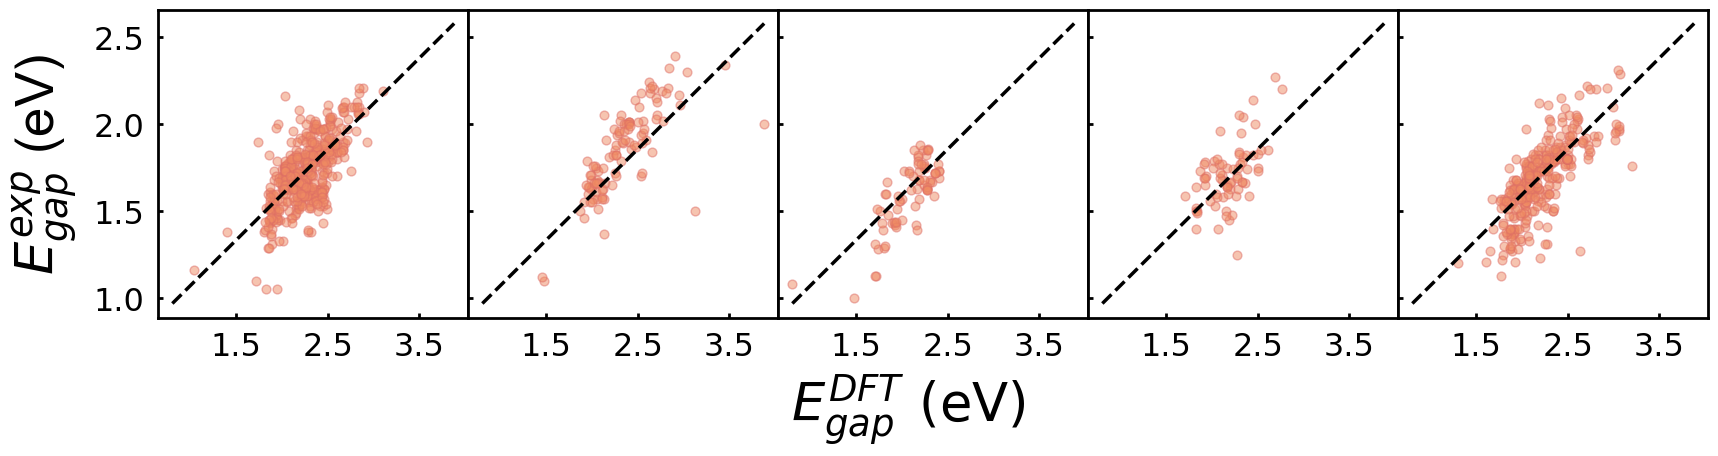

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True, gridspec_kw={'wspace': 0})
for i,label in enumerate(label_list):

    axes[i].plot((xmin,xmax), (ymin,ymax), ls='--', c='black', linewidth=2.5)
    x = df_data[df_data['type']==i]['HOMO-LUMO(eV)']
    y = df_data[df_data['type']==i]['bandgap(eV)']
    axes[i].scatter(x=x, y=y, label=label, s=40, 
                    alpha=0.5, 
#                     edgecolor='black',
                    edgecolor='#DE6E66',
                    linewidth=1,
#                     color=colors[i]
                    color = '#ef8a62'
                   )
#     axes[i].legend(fontsize=22)

    xticks = [1.5,2.5,3.5]
#     xticks = [1,3,5]
    yticks=[1,1.5,2,2.5]

    axes[i].set_xticks(xticks)
    axes[i].set_yticks(yticks)
    axes[i].tick_params(direction='in', width=2)
    axes[i].tick_params(axis='x', labelsize=23, pad=10)
    axes[i].tick_params(axis='y', labelsize=23, pad=10)
#     axes[i].set_xlim(xmin,xmax)
#     axes[i].set_ylim(xmin,xmax)
    if i==0:
        axes[i].set_ylabel('$E_{gap}^{exp}$ (eV)', fontsize=38, font="arial", labelpad=10)

    for spine in axes[i].spines.values():
        spine.set_linewidth(2)
fig.text(0.5, -0.15, '$E_{gap}^{DFT}$ (eV)', ha='center', fontsize=38)
plt.show()

# put in one chart

In [90]:
colormap = plt.get_cmap('Accent')
# colormap = plt.get_cmap('Reds')
colors = colormap(np.linspace(0,1,5))
len(colors)

5

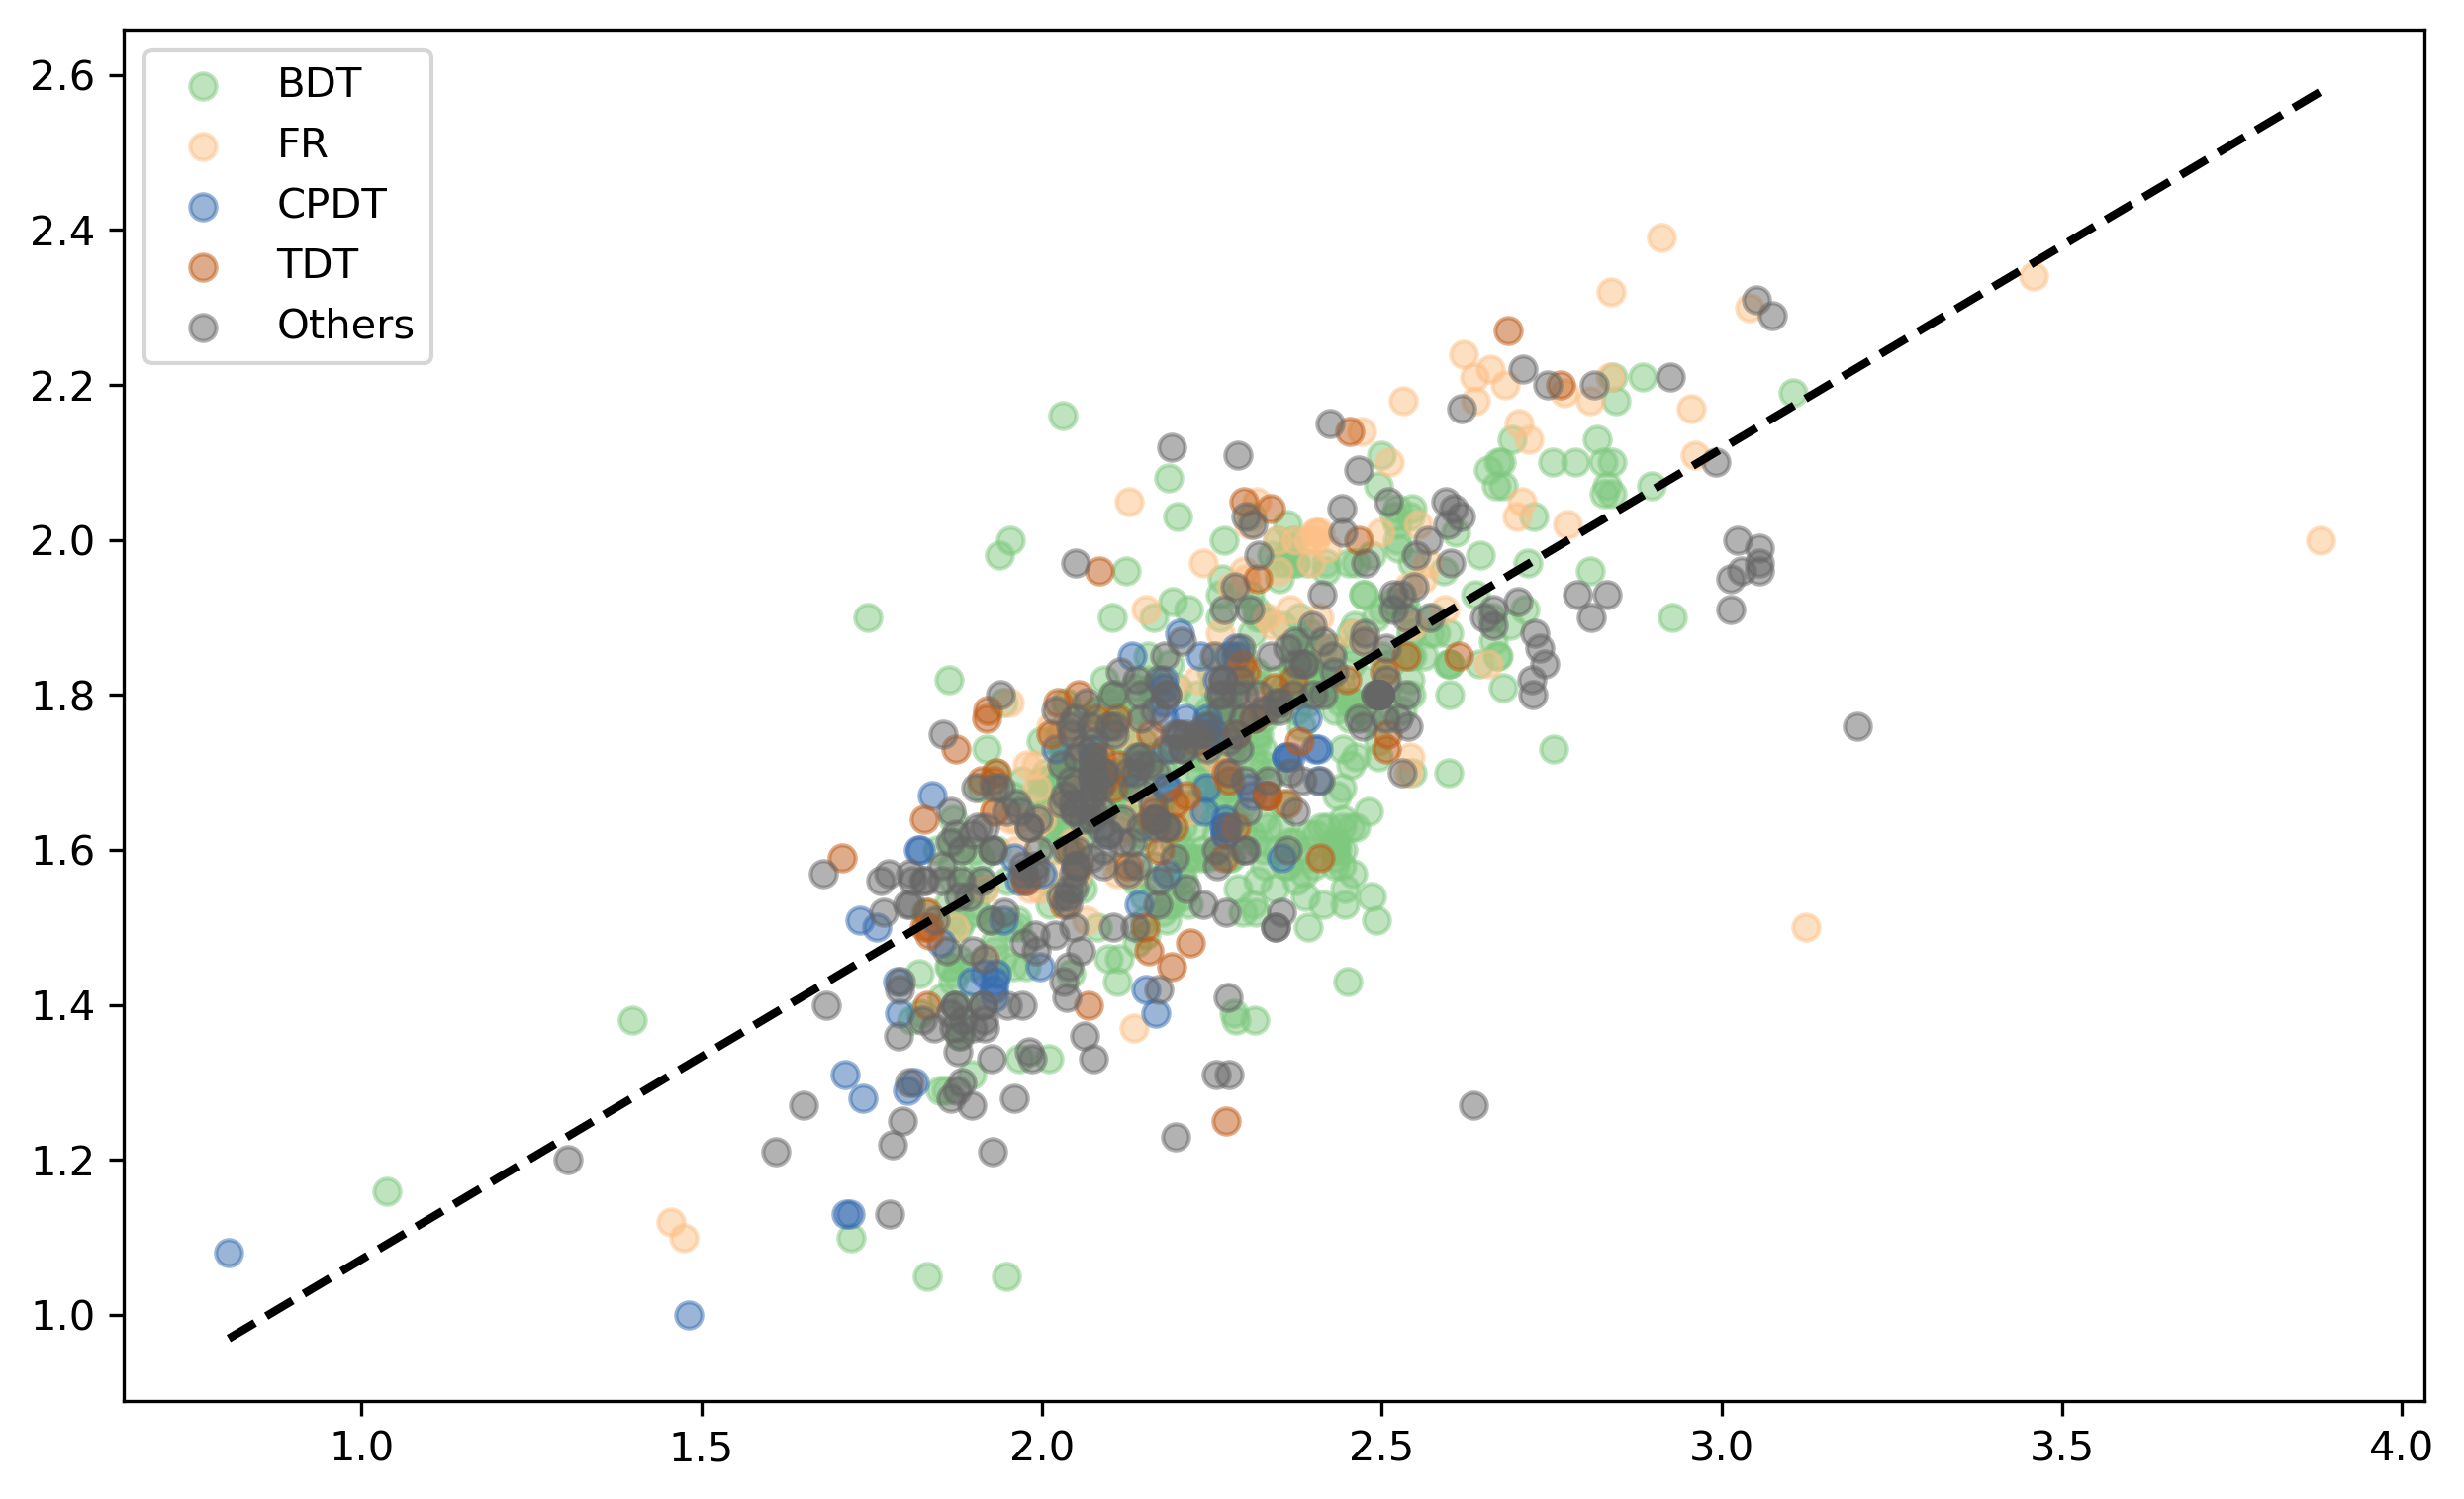

In [91]:
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
for i in range(5):
    X = df_data[df_data['type']==i]['HOMO-LUMO(eV)']
    y = df_data[df_data['type']==i]['bandgap(eV)']
    plt.scatter(X, y, label=label_list[i], s=40, alpha=0.5, color=colors[i])  # 绘制散点图，并设置标签
    
plt.plot((xmin,xmax), (ymin,ymax), ls='--', c='black', linewidth=2.0)

plt.legend()
plt.show()

# pi chart plot

In [94]:
df_data['type'].value_counts()

0    512
4    329
1    107
2     75
3     73
Name: type, dtype: int64

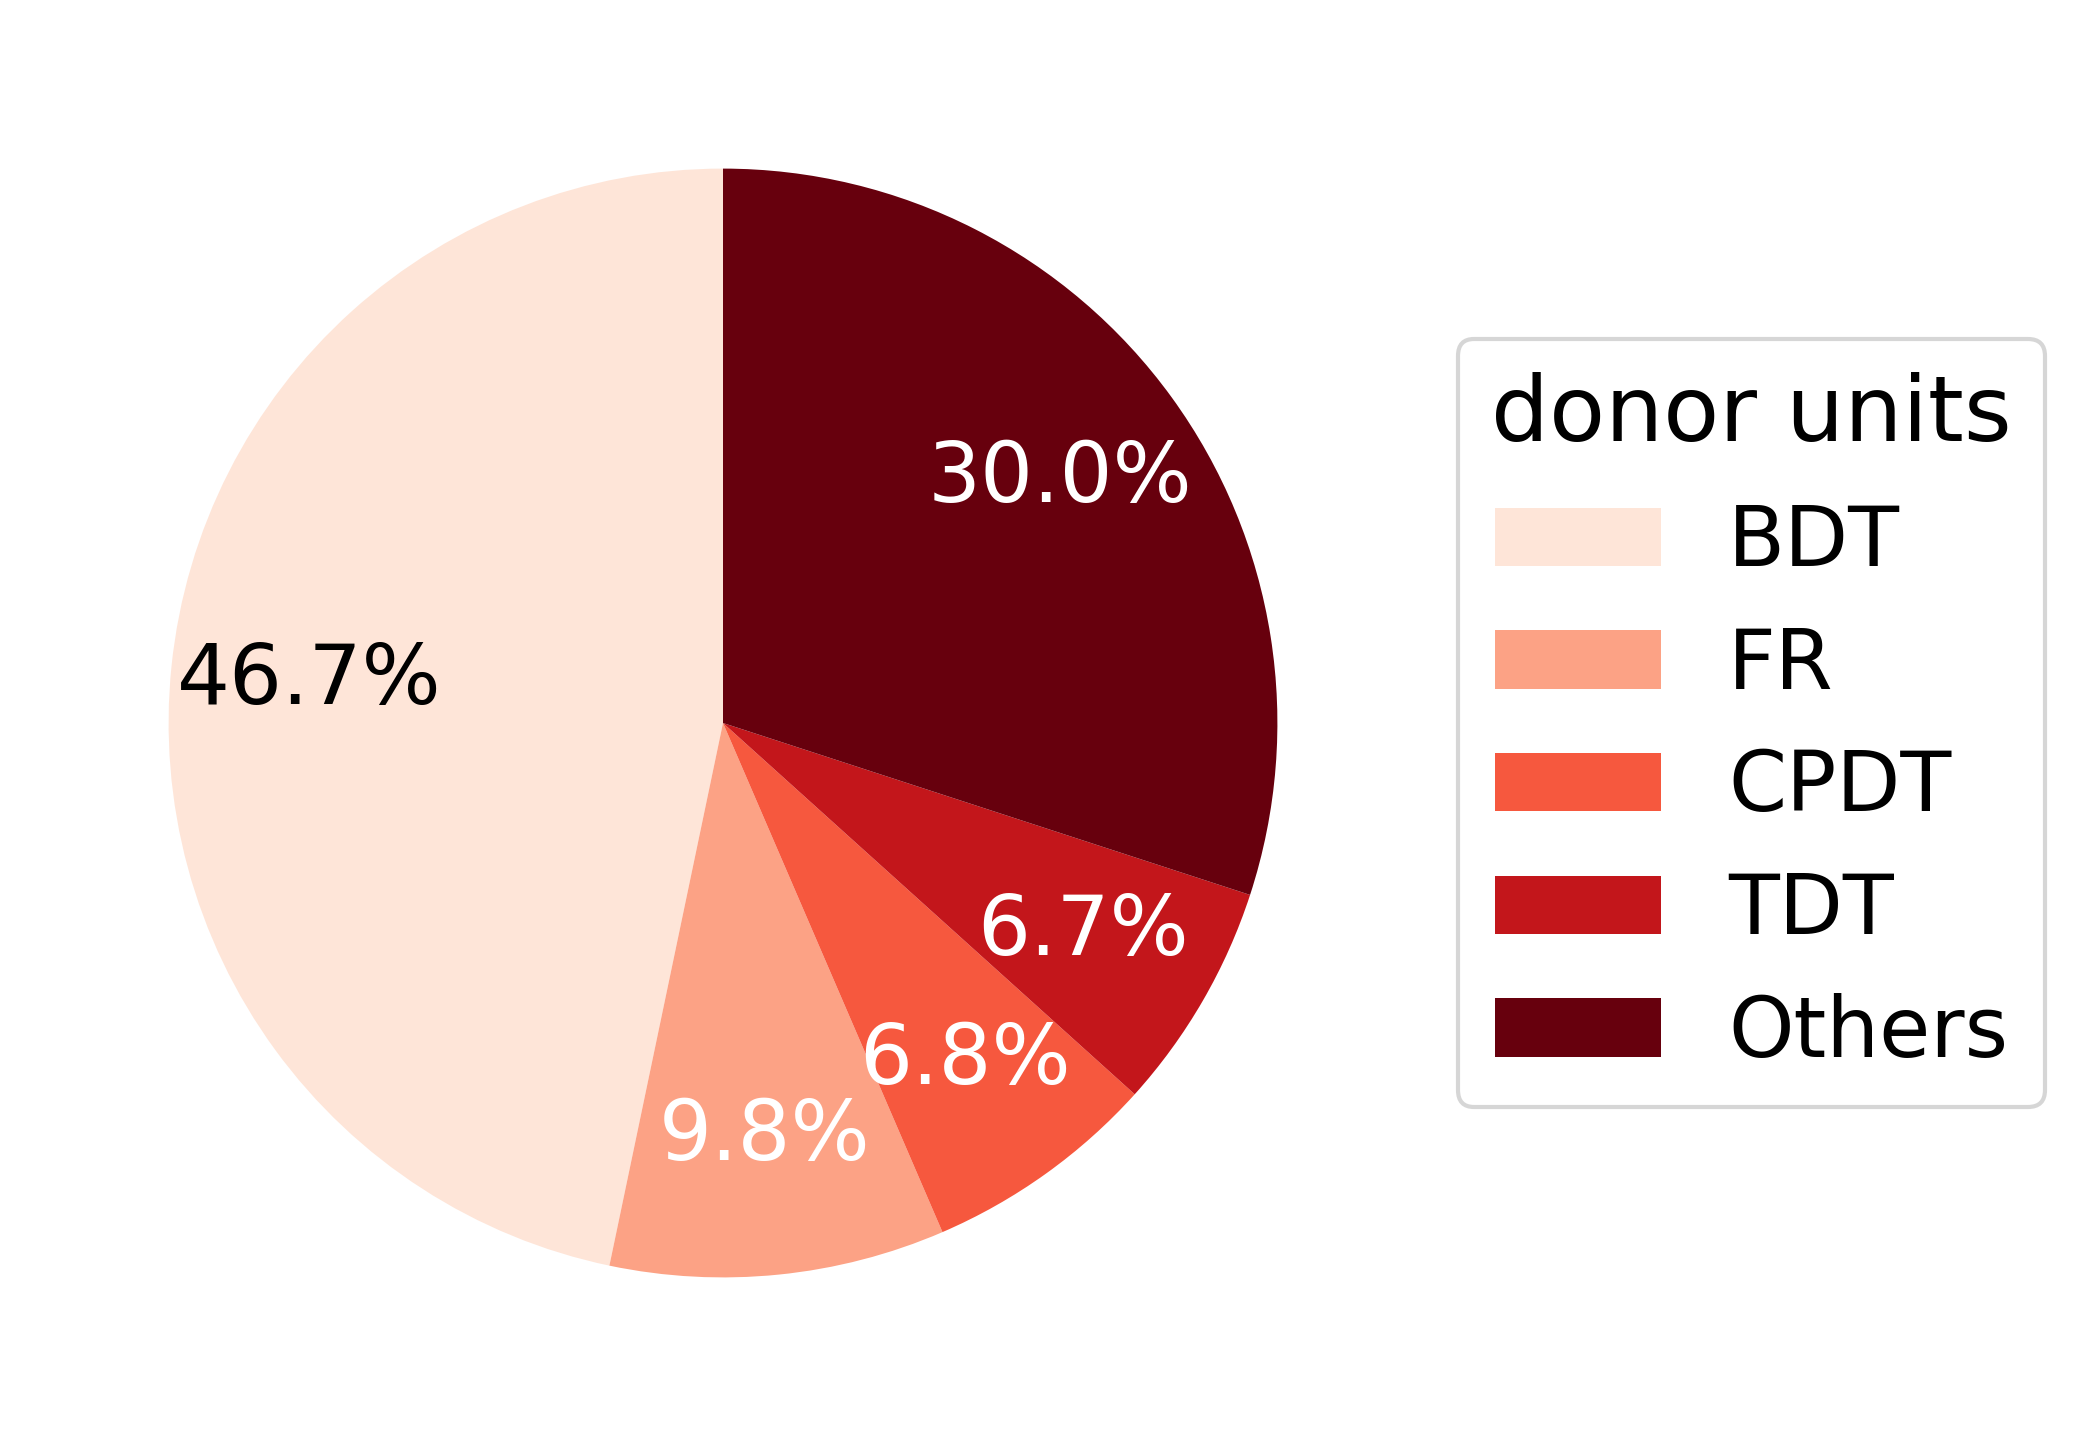

In [125]:
import matplotlib.pyplot as plt

# 饼状图数据
sizes = [512, 107, 75, 73, 329]
label_list = ['BDT', 'FR', 'CPDT', 'TDT', 'Others']

colormap = plt.get_cmap('Reds')
colors = colormap(np.linspace(0.1,1,5))

plt.figure(figsize=(6, 6), dpi=300)
patches, texts, autotexts = plt.pie(sizes, 
                            #         labels=label_list, 
                                    autopct='%1.1f%%', 
                                    startangle=90, 
#                                     labeldistance=0.9, 
                                    pctdistance=0.75,
                                    textprops={'fontsize': 20,
                                              'color': 'white'},
                                   colors=colors)  
# autopct='%1.1f%%'表示显示百分比，startangle=90表示从90度开始绘制扇区
autotexts[0].set_color('black')

legend = plt.legend(patches, label_list,#添加图例
#           title="donor unit",
          loc="center left",
          fontsize=20,
          bbox_to_anchor=(1, 0, 0.5, 1))
legend.set_title('donor units', prop={'size': 22})

plt.show()
